# Train on padded data

In [15]:
import geopandas as gpd
import pandas as pd
import copy
import os
import warnings
import random
from pprint import pprint
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import json

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_seq = self.X.iloc[idx].values
        y_val = self.y.iloc[idx]

        X_tensor = torch.tensor([item for item in X_seq], dtype=torch.float32)
        y_tensor = torch.tensor(y_val, dtype=torch.float32)

        return X_tensor, y_tensor

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [5]:
H3_RESOLUTION = 8
seq_length = 15
data_path = 'input_data'
path = f'data_res{H3_RESOLUTION}_seq{seq_length}'
path = os.path.join(data_path, path)

In [6]:
import pickle

with open(os.path.join(path, 'train.pkl'), 'rb') as f:
    X_train, y_train = pickle.load(f)

In [7]:
# X_train, y_train = torch.load(os.path.join(path, 'train.pt'))
# X_test, y_test = torch.load(os.path.join(path, 'test.pt'))
with open(os.path.join(path, 'test.pkl'), 'rb') as f:
    X_test, y_test = pickle.load(f)

In [8]:
#padding
# (105165, 8) (105165,)
# (26292, 8) (26292,)

#8 15
# (135822, 15) (135822,)
# (36604, 15) (36604,)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(135822, 15) (135822,)
(36604, 15) (36604,)


In [9]:
# Dataframe
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

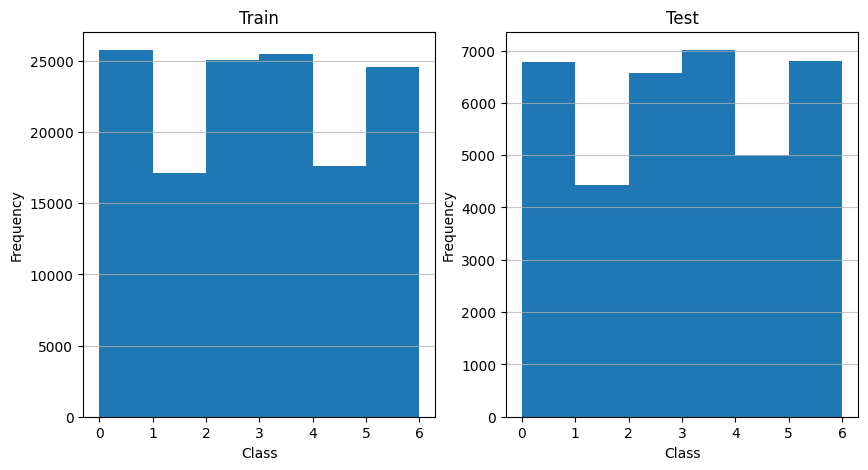

In [10]:
dist = []
for i in y_train:
    id_max = np.argmax(i)
    dist.append(id_max)

test_dist = []
for i in y_test:
    id_max = np.argmax(i)
    test_dist.append(id_max)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(dist, bins=range(7))
ax[0].set_title('Train')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')
ax[0].grid(axis='y', alpha=0.75)

ax[1].hist(test_dist, bins=range(7))
ax[1].set_title('Test')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')
ax[1].grid(axis='y', alpha=0.75)
plt.show()

In [11]:
train_dataset = SequenceDataset(X_train, y_train)
test_dataset = SequenceDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# EXP 1

In [12]:
input_size = len(X_train.iloc[0][0])
hidden_size = 128
output_size = 6
num_layers = 2
dropout_rate = 0.5

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

Validation: 100%|██████████| 1144/1144 [00:12<00:00, 93.61batch/s, val_loss=0.975] 


Epoch [1/60], Loss: 1.3328, Val Loss: 1.2780


Validation: 100%|██████████| 1144/1144 [00:12<00:00, 94.32batch/s, val_loss=0.859] 


Epoch [2/60], Loss: 1.2957, Val Loss: 1.2502


Validation: 100%|██████████| 1144/1144 [00:12<00:00, 88.66batch/s, val_loss=0.85] 


Epoch [3/60], Loss: 1.2651, Val Loss: 1.2252


Validation: 100%|██████████| 1144/1144 [00:11<00:00, 99.85batch/s, val_loss=0.872] 


Epoch [4/60], Loss: 1.2414, Val Loss: 1.2148


Validation: 100%|██████████| 1144/1144 [00:14<00:00, 76.97batch/s, val_loss=0.808]


Epoch [5/60], Loss: 1.2221, Val Loss: 1.1961


Validation: 100%|██████████| 1144/1144 [00:14<00:00, 77.30batch/s, val_loss=0.776]


Epoch [6/60], Loss: 1.2077, Val Loss: 1.1885


Validation: 100%|██████████| 1144/1144 [00:18<00:00, 63.43batch/s, val_loss=0.801]


Epoch [7/60], Loss: 1.1892, Val Loss: 1.1897


Validation: 100%|██████████| 1144/1144 [00:19<00:00, 60.14batch/s, val_loss=0.783]


Epoch [8/60], Loss: 1.1780, Val Loss: 1.1699


Validation: 100%|██████████| 1144/1144 [00:10<00:00, 111.20batch/s, val_loss=0.807]


Epoch [9/60], Loss: 1.1663, Val Loss: 1.1586


Validation: 100%|██████████| 1144/1144 [00:08<00:00, 127.29batch/s, val_loss=0.704]


Epoch [10/60], Loss: 1.1557, Val Loss: 1.1588


Validation: 100%|██████████| 1144/1144 [00:09<00:00, 121.73batch/s, val_loss=0.75] 


Epoch [11/60], Loss: 1.1490, Val Loss: 1.1434


Validation: 100%|██████████| 1144/1144 [00:10<00:00, 110.70batch/s, val_loss=0.76] 


Epoch [12/60], Loss: 1.1378, Val Loss: 1.1383


Validation: 100%|██████████| 1144/1144 [00:09<00:00, 118.08batch/s, val_loss=0.759]


Epoch [13/60], Loss: 1.1301, Val Loss: 1.1435


Validation: 100%|██████████| 1144/1144 [00:10<00:00, 112.02batch/s, val_loss=0.756]


Epoch [14/60], Loss: 1.1239, Val Loss: 1.1363


Validation: 100%|██████████| 1144/1144 [00:10<00:00, 109.79batch/s, val_loss=0.695]


Epoch [15/60], Loss: 1.1173, Val Loss: 1.1276


Validation: 100%|██████████| 1144/1144 [00:10<00:00, 109.48batch/s, val_loss=0.679]


Epoch [16/60], Loss: 1.1095, Val Loss: 1.1316


Validation: 100%|██████████| 1144/1144 [00:10<00:00, 104.79batch/s, val_loss=0.735]


Epoch [17/60], Loss: 1.1069, Val Loss: 1.1195


Validation: 100%|██████████| 1144/1144 [00:10<00:00, 108.87batch/s, val_loss=0.743]


Epoch [18/60], Loss: 1.0973, Val Loss: 1.1164


Validation: 100%|██████████| 1144/1144 [00:11<00:00, 101.93batch/s, val_loss=0.673]


Epoch [19/60], Loss: 1.0946, Val Loss: 1.1229


Validation: 100%|██████████| 1144/1144 [00:09<00:00, 120.39batch/s, val_loss=0.75] 


Epoch [20/60], Loss: 1.0904, Val Loss: 1.1150


Validation: 100%|██████████| 1144/1144 [00:10<00:00, 104.90batch/s, val_loss=0.752]


Epoch [21/60], Loss: 1.0840, Val Loss: 1.1135


Validation: 100%|██████████| 1144/1144 [00:10<00:00, 105.45batch/s, val_loss=0.716]


Epoch [22/60], Loss: 1.0808, Val Loss: 1.1145


Validation: 100%|██████████| 1144/1144 [00:12<00:00, 95.18batch/s, val_loss=0.716] 


Epoch [23/60], Loss: 1.0772, Val Loss: 1.1074


Validation: 100%|██████████| 1144/1144 [00:11<00:00, 100.18batch/s, val_loss=0.726]


Epoch [24/60], Loss: 1.0722, Val Loss: 1.1162


Validation: 100%|██████████| 1144/1144 [00:11<00:00, 95.50batch/s, val_loss=0.647] 


Epoch [25/60], Loss: 1.0694, Val Loss: 1.1055


Validation: 100%|██████████| 1144/1144 [00:11<00:00, 97.47batch/s, val_loss=0.702] 


Epoch [26/60], Loss: 1.0651, Val Loss: 1.1144


Validation: 100%|██████████| 1144/1144 [06:33<00:00,  2.91batch/s, val_loss=0.72] 


Epoch [27/60], Loss: 1.0601, Val Loss: 1.1146


Validation: 100%|██████████| 1144/1144 [00:10<00:00, 109.48batch/s, val_loss=0.682]


Epoch [28/60], Loss: 1.0585, Val Loss: 1.1163


Validation: 100%|██████████| 1144/1144 [00:10<00:00, 112.33batch/s, val_loss=0.68] 


Epoch [29/60], Loss: 1.0552, Val Loss: 1.1120


Validation: 100%|██████████| 1144/1144 [00:10<00:00, 109.14batch/s, val_loss=0.686]


Epoch [30/60], Loss: 1.0530, Val Loss: 1.1069
Early stopping triggered


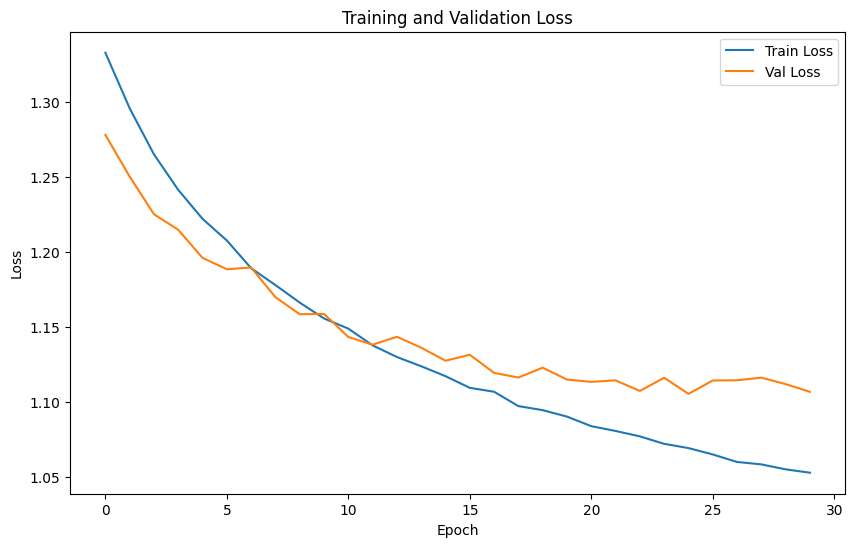

In [14]:
# Training loop with early stopping
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

patience = 5
num_epochs = 60

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Dodanie tqdm do pętli batch'y treningowych
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    for i, (inputs, targets) in enumerate(train_loader_tqdm):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predicted_one_hot = torch.nn.functional.one_hot(preds, num_classes=7).float()
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Aktualizacja opisu tqdm dla batch'y
        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0

    # Dodanie tqdm do pętli batch'y walidacyjnych
    test_loader_tqdm = tqdm(test_loader, desc="Validation", unit="batch")
    with torch.no_grad():
        for inputs, targets in test_loader_tqdm:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Aktualizacja opisu tqdm dla batch'y walidacyjnych
            test_loader_tqdm.set_postfix(val_loss=loss.item())

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# best model
model.load_state_dict(torch.load('best_model.pth'))

# Train/test plot
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test

In [16]:
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).long()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
true_labels = np.argmax(true_labels, axis=1)
predicted_labels = np.array(predicted_labels)

In [17]:
test_accuracy = accuracy_score(true_labels, predicted_labels)
test_precision = precision_score(true_labels, predicted_labels, average='weighted')
test_recall = recall_score(true_labels, predicted_labels, average='weighted')
test_f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58      6783
           1       0.58      0.50      0.54      4432
           2       0.59      0.65      0.62      6573
           3       0.60      0.63      0.61      7010
           4       0.56      0.48      0.52      5000
           5       0.60      0.63      0.62      6806

    accuracy                           0.59     36604
   macro avg       0.59      0.58      0.58     36604
weighted avg       0.59      0.59      0.59     36604


# Train

In [18]:
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).long()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
true_labels = np.argmax(true_labels, axis=1)
predicted_labels = np.array(predicted_labels)

train_accuracy = accuracy_score(true_labels, predicted_labels)
train_precision = precision_score(true_labels, predicted_labels, average='weighted')
train_recall = recall_score(true_labels, predicted_labels, average='weighted')
train_f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.66      0.67      0.67     25778
           1       0.67      0.56      0.61     17167
           2       0.66      0.72      0.69     25112
           3       0.67      0.70      0.68     25526
           4       0.62      0.56      0.59     17657
           5       0.66      0.69      0.68     24582

    accuracy                           0.66    135822
   macro avg       0.66      0.65      0.65    135822
weighted avg       0.66      0.66      0.66    135822


In [19]:
headers = ['Metric', 'Train', 'Test']
data = [
    ['Accuracy', train_accuracy, test_accuracy],
    ['Precision', train_precision, test_precision],
    ['Recall', train_recall, test_recall],
    ['F1', train_f1, test_f1]
]

print(tabulate(data, headers=headers, tablefmt='fancy_grid'))

╒═══════════╤══════════╤══════════╕
│ Metric    │    Train │     Test │
╞═══════════╪══════════╪══════════╡
│ Accuracy  │ 0.659981 │ 0.589034 │
├───────────┼──────────┼──────────┤
│ Precision │ 0.65952  │ 0.588151 │
├───────────┼──────────┼──────────┤
│ Recall    │ 0.659981 │ 0.589034 │
├───────────┼──────────┼──────────┤
│ F1        │ 0.658676 │ 0.587497 │
╘═══════════╧══════════╧══════════╛


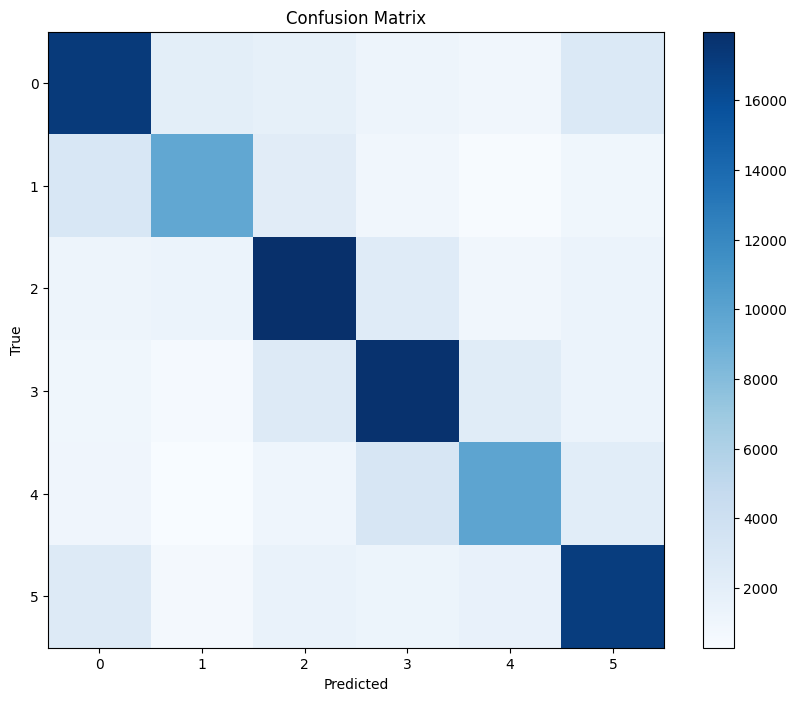

In [20]:
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix(true_labels, predicted_labels), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:

results = {
    f'model_res{H3_RESOLUTION}_seq{seq_length}': {
        'train': {
            'accuracy': train_accuracy,
            'precision': train_precision,
            'recall': train_recall,
            'f1': train_f1
        },

        'test': {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1
        }
    }
}

with open('results.json', 'a') as f:
    json.dump(results, f, indent=4)